In [17]:
import numpy as np
from qiskit import *
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit_aer import AerSimulator

### Main loop

{'00000': 2, '00001': 1, '00010': 3, '00011': 2, '00100': 4, '00101': 4, '00110': 4, '00111': 4, '01000': 1, '01001': 1, '01010': 2, '01011': 2, '01100': 3, '01101': 4, '01110': 3, '01111': 4, '10000': 3, '10001': 2, '10010': 4, '10011': 3, '10100': 4, '10101': 4, '10110': 4, '10111': 4, '11000': 2, '11001': 2, '11010': 3, '11011': 3, '11100': 3, '11101': 4, '11110': 3, '11111': 4}


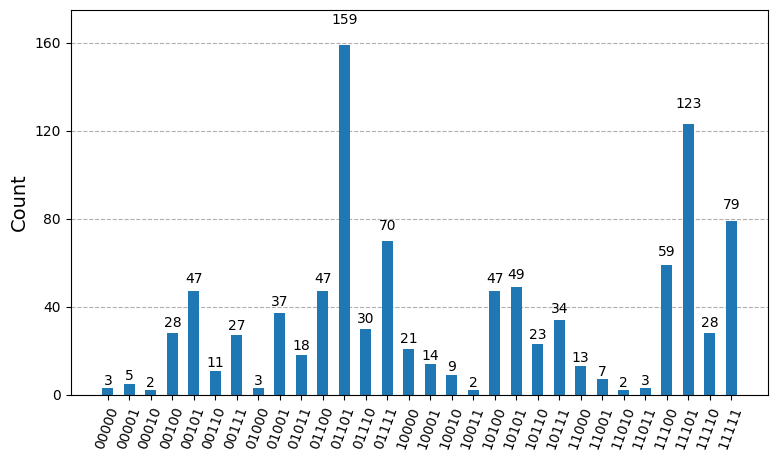

In [31]:
def max2sat_qaoa(gamma, beta, clauses):
    num_bits, c_mappings = classical_parser(clauses)
    print(c_mappings)
    tot_qubits = num_bits + 1 + len(clauses)
    qc = QuantumCircuit(tot_qubits, num_bits) #need an extra qubit for the helper and a "helper qubit for each clause"
    qc.x(tot_qubits - 1)
    for i in range(num_bits):
        qc.h(i)
    qc.barrier()
    separator(qc, clauses, num_bits, tot_qubits) #separator
    for i in range(num_bits, tot_qubits-1):
        qc.cp(-1*gamma,i, tot_qubits-1) #apply the phase gates to the |1> qubit from each clauses' helper bit
    qc.barrier()
    separator(qc, clauses, num_bits, tot_qubits)
    qc.barrier()
    mixer(qc, clauses, num_bits, beta)#mixer
    qc.barrier()
    for bit in range(num_bits):
        qc.measure(bit, bit)   
    qc.draw()


    backend = AerSimulator()

    # Transpile the ideal circuit to a circuit that can be directly executed by the backend
    transpiled_circuit = transpile(qc, backend)

    # Since the output will be deterministic, we can use just a single shot to get it
    job = backend.run(transpiled_circuit, shots=1000, memory=True)
    output = job.result().get_counts()

    return qc, output


#circ, outputs = max2sat_qaoa(np.pi/4, np.pi/4, ([0], [1], [2], [3])) ## Test 1
circ, outputs = max2sat_qaoa(np.pi/4, np.pi/4, ([0,2], [2,3], [-1,4], [2,-4])) ##Test 2

#circ.draw(output = 'mpl')
plot_histogram(outputs, figsize=(9,5))

### Parse input, generate classical 'Count' function

In [30]:
def classical_parser(clauses):
    num_qubits = max(max(abs(x) for x in tup) for tup in clauses) + 1
    mappings = {}
    for val in range(2**num_qubits): #loop over each possible state (i.e. the binary values in 0 -> 2**n)
        cstate = bin(val)[2:].zfill(num_qubits)
        count = clause_checker(cstate, clauses)  
        mappings[cstate] = count  
    return num_qubits, mappings #return the number of qubits needed and a dict mapping each state_vec to it's C value 

def clause_checker(vec, clauses):
    bool_vec = [bool(int(bit)) for bit in vec] #converts state to array of booleans, 0=False 1=True
    counter = 0
    for c in clauses:
        temp_bool_vec = bool_vec.copy()
        if len(c) == 1: #if this is just a single instruction clause
            if c[0] < 0:
                temp_bool_vec[np.abs(c[0])] = not(temp_bool_vec[np.abs(c[0])])
            if temp_bool_vec[np.abs(c[0])] == True:
                counter = counter+1
        else:
            if c[0] < 0: #if the first elem in the clause has a not sign 
                temp_bool_vec[np.abs(c[0])] = not(temp_bool_vec[np.abs(c[0])])
            if c[1] < 0: #if the second elem has a not sign
                temp_bool_vec[np.abs(c[1])] = not(temp_bool_vec[np.abs(c[1])])
            if temp_bool_vec[np.abs(c[0])] or temp_bool_vec[np.abs(c[1])] == True:
                counter = counter+1
    return counter

### Separator & mixer

In [29]:
def separator(qc, clauses, num_bits, tot_qubits):
    for c in range(len(clauses)): #if the clause is just a variable assignment, 
        if len(clauses[c]) == 1:
            if clauses[c][0] < 0: #if it is not(x1) we x,cp,x
                qc.x(np.abs(clauses[c][0]))
                qc.cx(np.abs(clauses[c][0]),num_bits+c)
                qc.x(np.abs(clauses[c][0]))
            else:
                 qc.cx(np.abs(clauses[c][0]), num_bits+c)
        else:
            if clauses[c][0] < 0 and clauses[c][1] >= 0: #if it is not(x1) we x,cp,x
                qc.x(np.abs(clauses[c][0]))
                qc.cx(np.abs(clauses[c][0]),num_bits+c) #if just clause 1
                qc.cx(np.abs(clauses[c][1]),num_bits+c) #if just clause 2
                qc.mcx([np.abs(clauses[c][0]),np.abs(clauses[c][1])],num_bits+c)
                qc.x(np.abs(clauses[c][0]))
            elif clauses[c][0] >= 0 and clauses[c][1] < 0: #if it is not(x1) we x,cp,x
                qc.x(np.abs(clauses[c][1]))
                qc.cx(np.abs(clauses[c][0]),num_bits+c) #if just clause 1
                qc.cx(np.abs(clauses[c][1]),num_bits+c) #if just clause 2
                qc.mcx([np.abs(clauses[c][0]),np.abs(clauses[c][1])],num_bits+c)
                qc.x(np.abs(clauses[c][1]))
            elif clauses[c][0] < 0 and clauses[c][1] < 0:
                qc.x(np.abs(clauses[c][0]))
                qc.x(np.abs(clauses[c][1]))
                qc.cx(np.abs(clauses[c][0]),num_bits+c) #if just clause 1
                qc.cx(np.abs(clauses[c][1]),num_bits+c) #if just clause 2
                qc.mcx([np.abs(clauses[c][0]),np.abs(clauses[c][1])],num_bits+c)
                qc.x(np.abs(clauses[c][0]))
                qc.x(np.abs(clauses[c][1]))
            else:
                qc.cx(np.abs(clauses[c][0]),num_bits+c) #if just clause 1
                qc.cx(np.abs(clauses[c][1]),num_bits+c) #if just clause 2
                qc.mcx([np.abs(clauses[c][0]),np.abs(clauses[c][1])],num_bits+c)
        qc.barrier()
    return


def mixer(qc, clauses, num_bits, beta):
    for i in range(num_bits):
        qc.rx(2*beta, i)
    return